# Homework 04 - Applied Machine Learning


In [15]:
# imports
%matplotlib inline
import numpy as np
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx

# constants
DATA_PATH = 'lalonde.csv'

In [17]:
# fetch the dataset of the study: "Evaluating the Econometric Evaluations of Training Programs"
orig_data = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
data_mod = orig_data

# extrapolate white column in dataframe
arr_with_ones = [1] * len(data_mod['hispan'])
whites = arr_with_ones - (data_mod['hispan'] + data_mod['black'])
# create white-column in 
data_mod = data_mod.assign(white = whites.values)

print(data_mod.describe())


            treat         age        educ       black      hispan     married  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.301303   27.363192   10.268730    0.395765    0.117264    0.415309   
std      0.459198    9.881187    2.628325    0.489413    0.321997    0.493177   
min      0.000000   16.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   20.000000    9.000000    0.000000    0.000000    0.000000   
50%      0.000000   25.000000   11.000000    0.000000    0.000000    0.000000   
75%      1.000000   32.000000   12.000000    1.000000    0.000000    1.000000   
max      1.000000   55.000000   18.000000    1.000000    1.000000    1.000000   

         nodegree          re74          re75          re78       white  
count  614.000000    614.000000    614.000000    614.000000  614.000000  
mean     0.630293   4557.546569   2184.938207   6792.834483    0.486971  
std      0.483119   6477.964479   3295.679043   

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)


Before we start the analysis we will define some useful plotting functions to evaluate distributions through, boxplots, histograms etc.

In [21]:
def barplot_categories(data):
    """ Plot the categorical data(black, hispan, white, married, nodegree) in a barplot, showing the 
    difference in distribution between the different treatment groups"""
    # the categories we want to plot
    categories = ['black','hispan','white', 'married', 'nodegree']
    sns.set_style("whitegrid")
    
    # create subplots and get 're78' data from the different groups
    fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(17, 5), sharey=True)
    
    # iterate and barplot the different categories
    for i, x in enumerate(categories):
        ax = sns.barplot(x='treat', y=x, data=data, estimator=lambda x: sum(x==1)*100.0/len(x), 
                         ax=axes[i], errwidth=1.2, capsize=0.1)
        ax.set(ylabel=x, title='Percent %s per treatment' % x)
    plt.show()

def boxplot_and_violinplot(data, var, title):
    ''' Add boxplot and violinplot for given variable in the data. 
        It is analyzed with regards to control and treatment'''
    # create subplots and get 're78' data from the different groups
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    treat0_var = data[data.treat == 0][var]
    treat1_var = data[data.treat == 1][var]

    # plot box plots
    # bootstrap specifies the number of times to bootstrap the median to determine its 95% confidence intervals. 
    axes[0].boxplot([treat0_var, treat1_var], notch=True, bootstrap=5000, showfliers=True)
    axes[0].set_title('box plot')
    
    # plot violin plots 
    axes[1].violinplot([treat0_var, treat1_var], showmeans=True, showmedians=False)
    axes[1].set_title('violin plot')

    # add horisontal grid lines
    for ax in axes:
        ax.yaxis.grid(True)
        ax.set_xticks([y+1 for y in range(len([treat0_var, treat1_var]))])
        ax.set_xlabel('group')
        ax.set_ylabel(title)
    # add tick labels
    plt.setp(axes, xticks=[y+1 for y in range(len([treat0_var, treat1_var]))],
             xticklabels=['control group', 'treated group'])
    plt.show()

def histogram_and_estdist(data, var, title):
    ''' Add a histogram and estimated distribution of given variable in the data.
        It is analyzed with regards to control and treatment'''
    # create subplots and get 're78' data from the different groups
    treat0_var = data[data.treat == 0][var]
    treat1_var = data[data.treat == 1][var]
    fig, (plot1, plot2) = plt.subplots(ncols=2)
    fig.set_size_inches(16, 6)
    
    # create histograms distribution plots
    plot1 = sns.distplot(treat0_var,kde=False, ax=plot1)
    plot1 = sns.distplot(treat1_var,kde=False, ax=plot1)
    plot1.set_title(title)
    
    # create estimated distribution plots
    plot2 = sns.distplot(treat0_var, hist=False, ax=plot2)
    plot2 = sns.distplot(treat1_var, hist=False, ax=plot2)
    plot2.set_title(title + " : estimated density")
    plt.show()
    print("Control group is blue and treated group is orange")

def eval_distribution(data, var, title):
    """ a gathering of some plots to evaluate distribution of continous or "fine" discrete variables """
    boxplot_and_violinplot(data, var, title)
    histogram_and_estdist(data, var, title)


___
## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

##### Assumptions:
As "naive" researchers we assume that we are only going to focus on the variables (re78) and (treat). We think "superficial" analysis is a full analysis where the goal is to determine the correlations between those variables. The "naive" part is assuming that there is no bias in the sampling and that one must not control for other features.

In [19]:
## We will present some key numbers for the variabel 're78' with respect to 'treat'
data = data_mod
treat0_78 = data[data.treat == 0]['re78']
treat1_78 = data[data.treat == 1]['re78']
# print out useful information about 're78'
print(treat0_78.describe())
print("\n", treat1_78.describe())

print('\nMean:%.f and median:%.f pay in control group' % (np.mean(treat0_78), np.median(treat0_78)))
print('Mean:%.f and median:%.f pay in treatment group' % (np.mean(treat1_78), np.median(treat1_78)))
print('Percentage difference in mean: %f%%' % (((np.mean(treat0_78)-np.mean(treat1_78))/((np.mean(treat0_78)+np.mean(treat1_78))*0.5)) * 100))
print('Percentage difference in median: %f%%' % (((np.median(treat0_78)-np.median(treat1_78))/((np.median(treat0_78)+np.median(treat1_78))*0.5)) * 100))


count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

 count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

Mean:6984 and median:4976 pay in control group
Mean:6349 and median:4232 pay in treatment group
Percentage difference in mean: 9.525408%
Percentage difference in median: 16.142724%


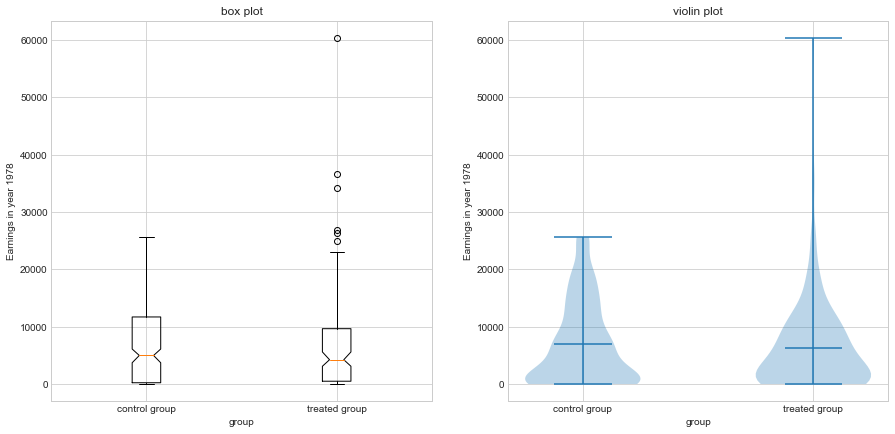

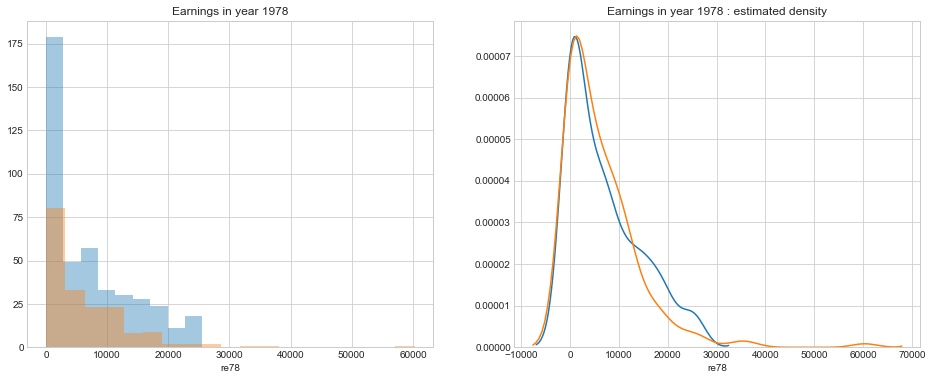

Control group is blue and treated group is orange


In [22]:
eval_distribution(data, 're78', 'Earnings in year 1978')

#### Explaination of plots:
BOX PLOT:
- The blue line is the median
- The notches show the 95% confidence interval of the median calculated by bootstrapping(5000)
- The boxes show the interquartile range(IQR): 25- and 75-percentiles or lower limit Q1 and higher limit Q3.
- The whiskers range are Q3 + 1.5*IQR and Q1 - 1.5*IQR. Beyond the whiskers point are considerendered outliers.

VIOLIN PLOT:
- To show a smoother approximation and more detailed distribution of the values
- Showing mean instead of median

HISTOGRAM: 
- It shows the count of different subject with earnings within the range of the bins.

ESTIMATED DISTRIBUTION:
- The curve is estimated to fit the data as well as it can. But it interpolates between datapoints, it is better at showing the trends, it is not a vizalization to conclude numbers from.

#### Comment: 
There are very many earnings that are 0 these heavely influence the boxplots and how we view the distributions. But when investigating the data i find that some earnings are extremely low. We think of this as a sign that even miniscules earnings of parttime jobs etc. is reported. The amount of unemployment is also extremely relevant in this study. So we did not remove them even though they distort the distribution alot. It would have been nice to have a feature that was "percentage of employment" as a feature.

##### How many unemployed?
Swarmplot to see the outliers better and look at amount of people without jobs better

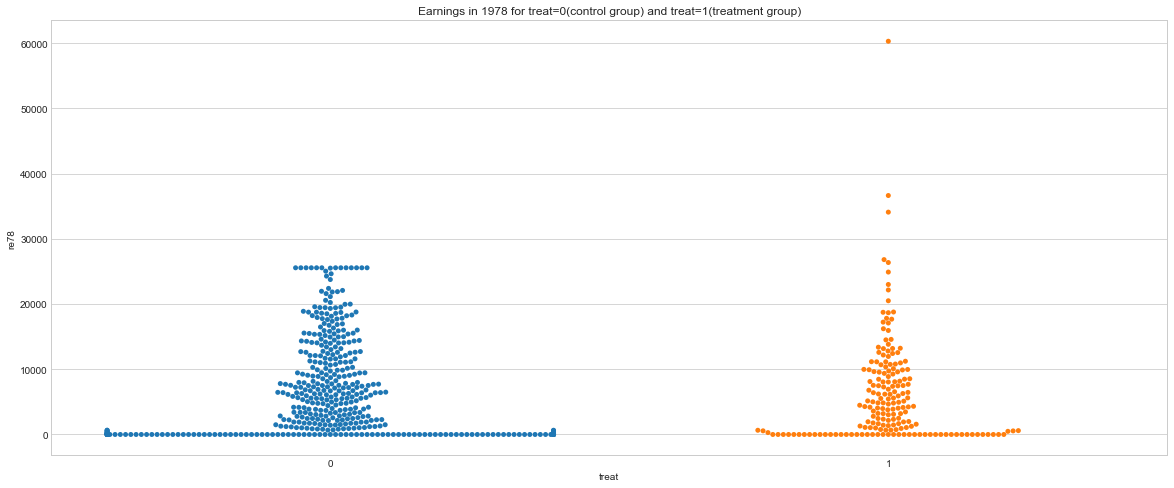

In [23]:
def swarmplot_re78(data):
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)

    ax = sns.swarmplot(x="treat", y="re78", data=data).set_title('Earnings in 1978 '
        'for treat=0(control group) and treat=1(treatment group)')

swarmplot_re78(data_mod)

The swarmplot show nicely some irregularities that the other plots didn't show as well. The people without work is better vizalized but hard to analyse because of the difference in group datapointsize. Something peculiar is the 14 people with exactly the same earning and the HIGHEST earnings. This is a area of the distribution where ne would thing the spacing between datapoints would stretch out. One could consider this an anomaly and remove it. This is the caveat of observational studies. We don't know why this has happened, is it a wrongdoing by the gatherer of information, is a questionaire bad designed, is the subject lying. Are they all working at the same job with the exact same pay? We can't know. And removing the datapoint can be as destructive for the analysis as having them there. So we will keep them for the analysis and assume they are correct

##### So what is the 95% confidence interval of these average pays?

To show the confidence interval we will concentrate only on the mean and median and not the whole distribution.
The central limit theorem states that sampling and taking the mean of the samples of any type of distribution will produce a normal distribution of means. Therefore we can ta a balanced 95% confidence interval to see if the treatment have had a noticable effect.

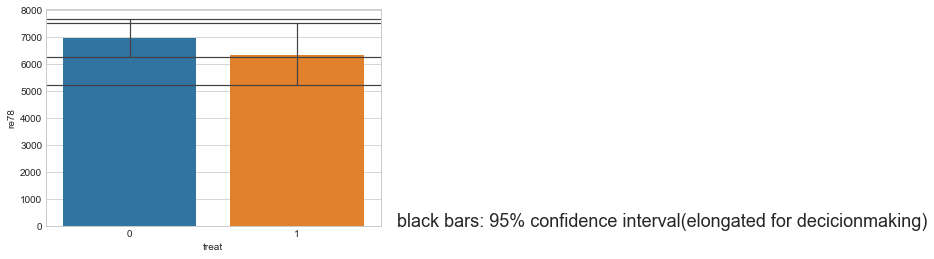

In [24]:
# plotting the mean of 're78' for the different 'treat' groups with 95% confidence interval
def barplot_re78(data):
    sns.set_style("whitegrid")
    # Extra long capsize is added for readability of capsize
    ax = sns.barplot(x='treat', y=data['re78'], data=data, estimator=np.mean, ci=95, n_boot=5000, capsize=3.5, errwidth=1.2)
    # adding text to clearify the black confidence interval
    ax.text(1.6, 0,'black bars: 95% confidence interval(elongated for decicionmaking)', fontsize=18)

barplot_re78(data)

###### What might a naive "researcher" conclude from this superficial analysis?
Assuming that the controlgroup and treatment group are not biased and that pay in '78 is a fair measurement of success in of the programs. It looks like the programs have not worked, the results seem to indicate that it have had a negative effect on the subject. Resulting in a measured reduction in mean pay for subject with treatment.
##### Hypothesis testing
The alternative hypothesis($H_{a}$) is that the treatment has an effect, while the null hypothesis($H_{0}$) is that the treatment has no effect(the control group beeing the measure of no effect). To see if there is a significant effect of the treatment we calculate if the treatment mean pay is outside a 95% confidence interval of the mean the control group. The treatmentgroup mean is within the 95% confidence interval of the control group. This is not considered as statistically significant. It does not mean that it is not an negative effect from the treatment, just that we can not conclude that it has one. The conclusion is that the $H_{0}$ hypothesis holds.

___
## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

###### Taking a closer look
We will examine the dataset and all it variable and test if the previous assumption made by the *'naive'* reasearcher is correct. Is there bias in the sampling done for the treatmentgroup and controlgroup. This is observational studies of a dataset, meaning we did not collect this data, so we should try to examine the origin of the data as well as extrapolate info from the data. We will try to plot the distributions of different variables both joint and marginal. Then we will investigate the corrolation between the features to see if there is a biased division of the treatmentgroups.

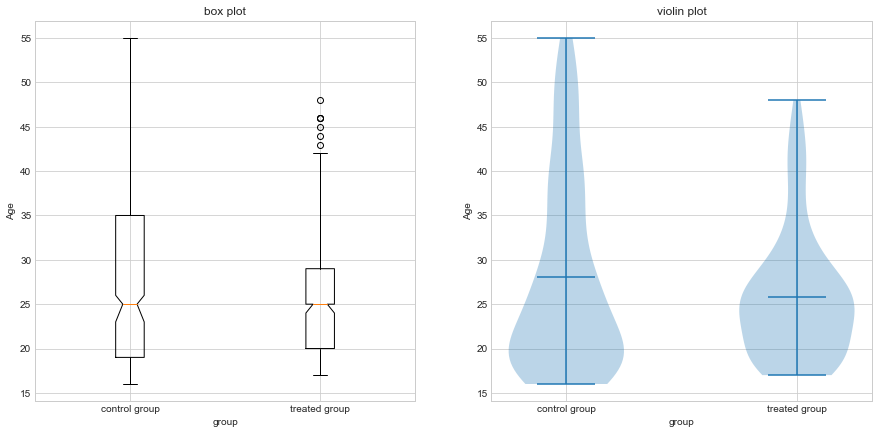

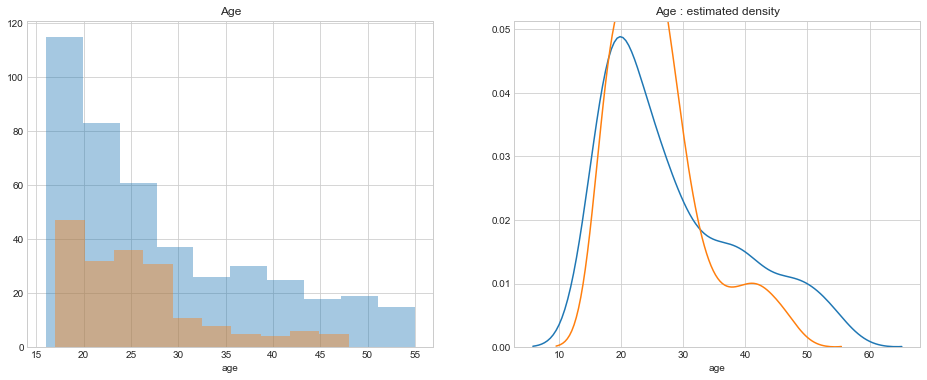

Control group is blue and treated group is green


In [8]:
eval_distribution(data_mod, 'age', 'Age')

#### Comment on age distribution:
- the mean is approximately the same but the distribution is difference, the variance is much bigger in the control group meaning they have slighty more youngster and much more people beyond 30. The treatment group have a focused age at late 20's


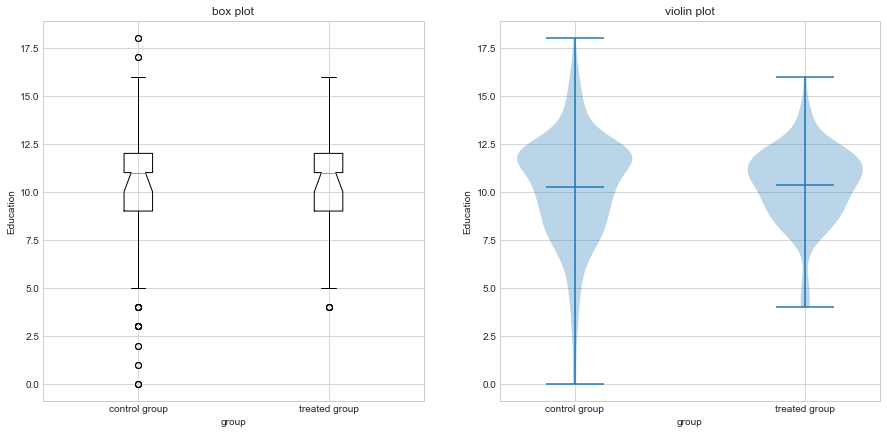

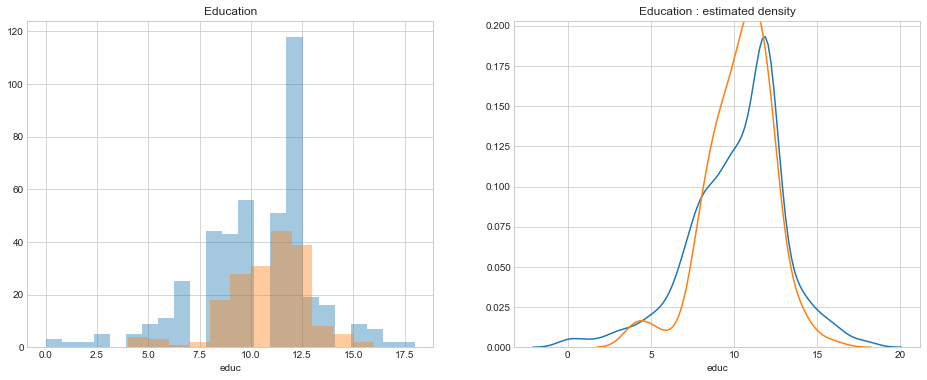

Control group is blue and treated group is green


In [9]:
eval_distribution(data_mod, 'educ', 'Education')

#### Comment on years of education distribution:
- One can see that the distributions are pretty similar, what I want to point out is that the control group has a spike that is twice as high as adjecent data at 12 years. The treatmentgroup has no such spike. It could be that they have some finish degree in something that make them more favorable to get hired. While the other education duration might be aimlessly taking some courses here and there is is less favorable in the jobmarket. But this is just speculation.

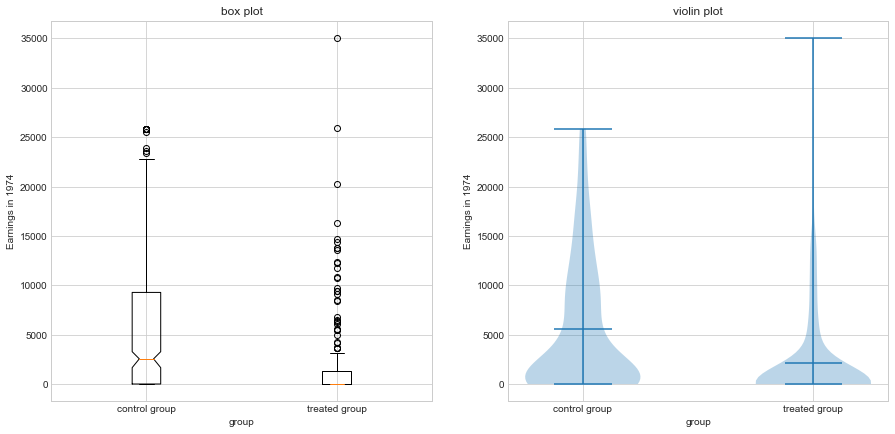

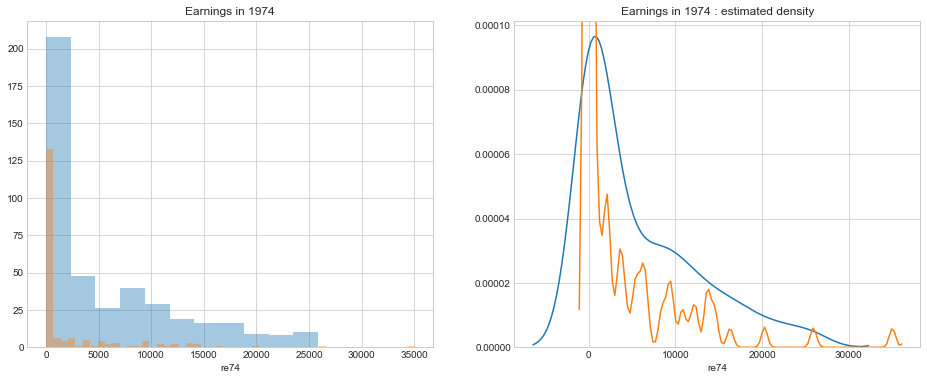

Control group is blue and treated group is green


In [10]:
eval_distribution(data_mod, 're74', 'Earnings in 1974')

#### Comment on Earnings in 1974 distribution:
- Extremely big difference in having an job or not. The treatmentgroup is domination by unemployment. More variance higher mean in controlgroup

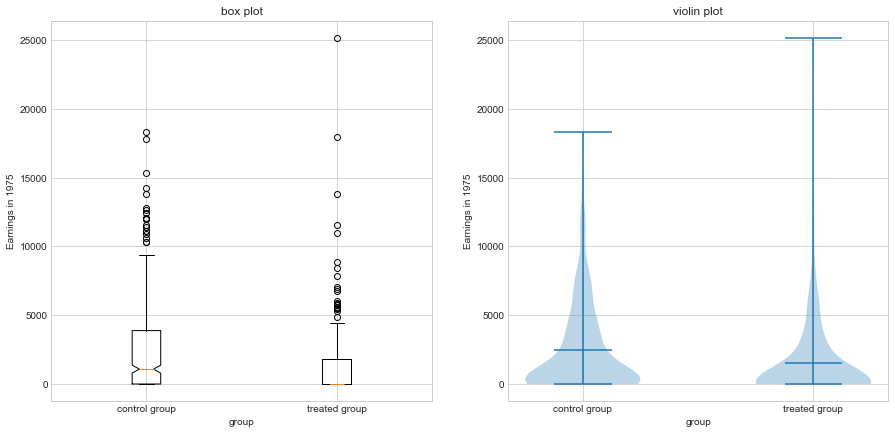

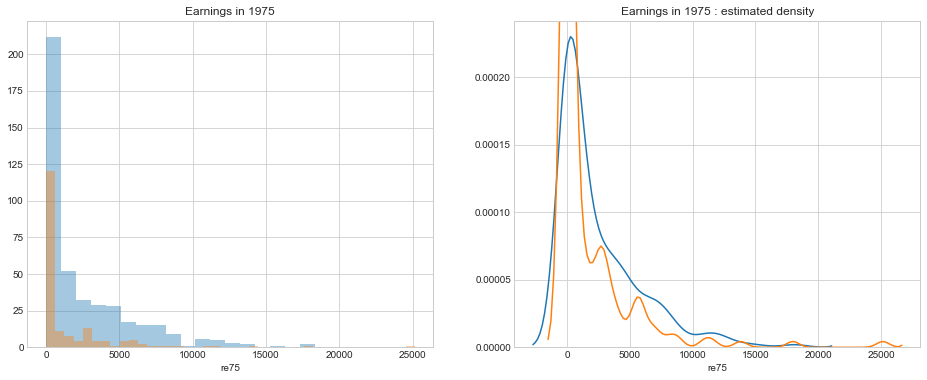

Control group is blue and treated group is green


In [11]:
eval_distribution(data_mod, 're75', 'Earnings in 1975')

#### Comment on Earnings in 1975 distribution:
- Lesser difference in 1975 distribution, but the treamentgroup still dominated by unemployment in a bigger degree than control group. Higher variance and mean for controlgroup


#### Summary about all the non-categorical features :
It looks like the constructer of the treatment and controlgroups have tried to control for some variables, but they have in that case on the variable mean beeing the same, but not the distributions. Examples are age, education. But it is a big unbalance in the previous earning of the different treatmentgroups. That very bad when the future earnings is the measure of success. One would thing that previous years earnings have acorrolation with later years of earnings. We will look at that corrolation after we take a look at the categorical information

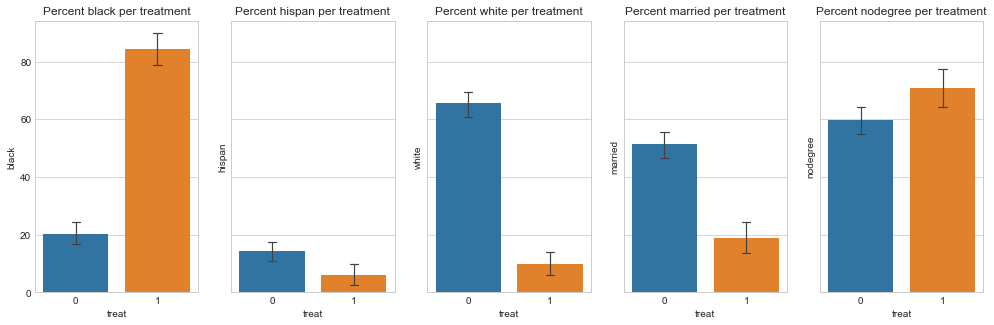

In [25]:
barplot_categories(data_mod)

#### Comment on the categorical features:
Here we can see a big difference in the compostion of races(and married) in the treatmentgroup compared to the controlgroup. The treatmentgroup are almost exclusively black people while the controlgroup have a big majority of white people.

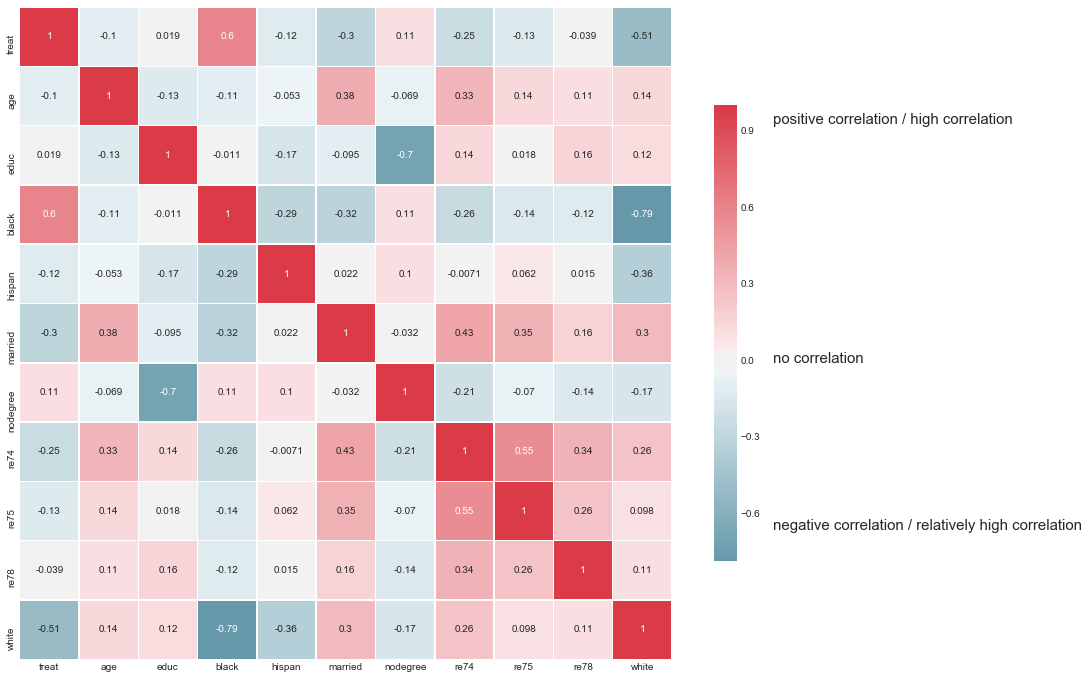

In [26]:
def corr_mat(data):
    # compute the correlation matrix
    correlation_matrix = data.corr()
    #print(correlation_matrix)

    # create the subplot
    f, ax = plt.subplots(figsize=(15, 12))
    # comment the colorbar
    ax.text(12.7, 1.97,'positive correlation / high correlation', fontsize=15)
    ax.text(12.7, 6.00,'no correlation', fontsize=15)
    ax.text(12.7, 8.82,'negative correlation / relatively high correlation', fontsize=15)
    # generate a colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # plot the correlationmatrix as a heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .7})

corr_mat(data_mod)

#### Comment:
- 'noDegree' and 'educ' has a very high negative corrolation. Meaning that people in generel have a higher chance of having a degree the longer the have studied vice versa.
- 're74' and 're75' have a very high positive corrolation. Meaning that if people had a high income in 1974 then the propably have that in 1975 as well and vice versa.

We would love to track down which features influence 're78' which is what we use as a measure of success in the program. All features have a positive correlation with 're78' except from 'no_degree','black', 'hispan' and of course 'treat' which it has a negative corrolation with. The latter could be because of causation. That is what we are investigating.
So all of these parameters impact the successparameter 're78'. Therefore for this to be a valid experiment one should see approximately no corrolation beetween 'treat' and the other features.

But look and behold. The 'treat' variable has a negative correlation most features, positive correlation with nodegree, and approximately no correlation with education and 're28'. This means the treatmentgroups are not from the 'same' population distributionwise with respect to these features. Second thing is that treatment has a negative correlation with features that have a high correlation with 're78'. This again means that the the group getting treatment had a far worse startingpoint than the control group.

This beeing a observational study it is hard to say anything definitive about why these group are divided like this. It might be that the people that are assigned to to these programs are more in "need" of these programs. Or that people that are well off denies the request and therefore become a controlgroup. This kind of self-selection can sometime be hard to control for long duration trials.

This of course invalidate the assumption the 'naive' researcher had, about the treatment groups beeing not biased. This again invalidate his conclusions and results.

___
## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)


#### Assumptions:
- For a propensity score model to work one has to assume that the "naive model" is true. The model says that one if one matches subject with exactly the same values for each feature, then one can calculate the propability of beeing treated. If the naive model is wrong it is because there are other "features" by these "subject" that help to contribute to the subjects probability of beeing treated except from the features we observed


In [27]:
data = data_mod
# create a logistic regression model
model = linear_model.LogisticRegression()

treatment = data.treat
# Create df for to train the model without columns 're78' and 'treat'
df_model = data.drop(['treat','re78'] , 1)

# fit the model with all the available data
model.fit(df_model, treatment)
# print the accuracy score for predictions of treatmentgroup or not.
print('The classification score it got on the same data:', model.score(df_model, treatment))
# predicting with probabilityscore (0.74 is 74% probability of belonging to treatmentgroup)
propensityscores = model.predict_proba(df_model)[:,1]
data_propensity = data.assign(propensity = pd.Series(propensityscores).values)
print('One can see below the columns and the weights in order(the weights belongs to the columns with the same index). ' 
      'The higher the weights are the higher the features impact the propensity score. '
      'One can see that the most influencial is black and white. While re74 and re75 have a comparatively low impact\n')
print(model.coef_)
print(df_model.columns)


The classification score it got on the same data: 0.817589576547
One can see below the columns and the weights in order(the weights belongs to the columns with the same index). The higher the weights are the higher the features impact the propensity score. One can see that the most influencial is black and white. While re74 and re75 have a comparatively low impact

[[ -1.36776779e-02  -2.14056285e-02   1.39676520e+00  -2.87937463e-01
   -5.08955800e-01   2.16863769e-02  -6.94399506e-05   3.22076674e-05
   -1.22572330e+00]]
Index(['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75',
       'white'],
      dtype='object')


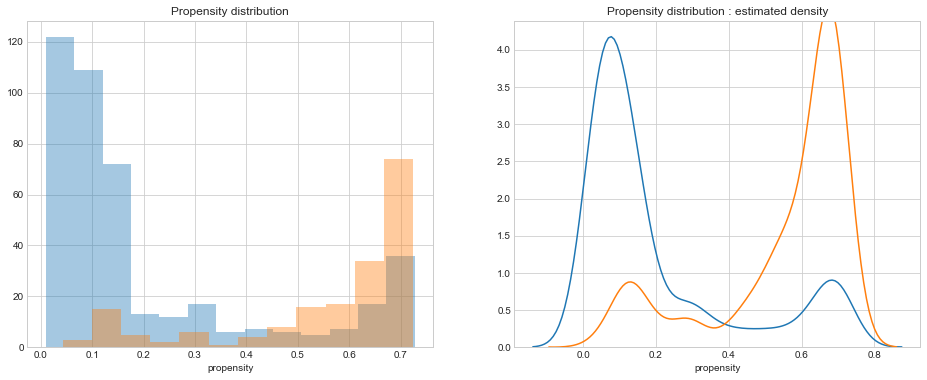

Control group is blue and treated group is orange


In [28]:
# plot the distribution of the propensityscore
data = data_propensity
histogram_and_estdist(data, 'propensity', 'Propensity distribution')

#### Comment to propensityscore distributions:
we can see that it predict the treatment group pretty nicely, but as we saw from the weights this is mostly done through the race information. One can se a small bump in the distribution at 0.3 which is probably because of a categorical feature which is not 'white' or 'black' which "creates" the big divide. I would guess it could be ''hispan and/or 'married' which has pretty high weights.

___
## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

##### A few words:
The naive matching is done through optimilizing ONLY the propencity score. It does not consider the "closeness" of the individual features.

In [31]:
def matching_groups(data, imp_features=None, threshold=0):
    
    A = data[data.treat==0]
    B = data[data.treat==1]

    # create a bipartite graph object with control group subjects and treatment group subjects
    G = nx.Graph()
    G.add_nodes_from(A, bipartite=0)
    G.add_nodes_from(B, bipartite=1)

    
    # iterate through the control an treated groups and add edges in the bipartite graps between the groups.
    for i, control in A.iterrows():
        for j, treated in B.iterrows():
            # Since the method we use is based on max matching we use negative value of the difference to get min_matching
            weight = 1-np.abs(control["propensity"] - treated["propensity"])
            # Choose which important features you want to balance further
            if imp_features is not None: 
                for f in imp_features:
                    weight += 0.01*(1 - np.abs(control[f] - treated[f]))

            if weight > threshold:
                G.add_edge(i, j, weight=weight)

    # Matching with maximizing the weights (the closer the propensity scores are between the subject, the higher the match-chance is)
    match = nx.max_weight_matching(G, maxcardinality= True)
    print("number of pairs that matches", len(match)/2)
    print('previous number of subjects in treatmentgroup/ max matches:', len(data[data.treat == 1]))

    # We want too only keep the matched treated and control for a balanced dataset
    # since the matches are mentioned two time with alternating key/value one can get all ID from keys()
    data_matched = data.filter(items=match.keys(), axis=0)

    print('\naverage propensityscores(control,treatment):', 
          (np.mean(data_matched[data_matched.treat == 0]['propensity']),
           np.mean(data_matched[data_matched.treat == 1]['propensity'])))
    
    return data_matched
    
data_naive_match = matching_groups(data=data_propensity)


number of pairs that matches 185.0
previous number of subjects in treatmentgroup/ max matches: 185

average propensityscores(control,treatment): (0.3813712946782137, 0.553677727154176)


### Analysis on the distribution of the features with naively matched dataset
- To spare the reader of too much infomation we will spare the full feature analysis and only show you the categorical distribution. It is sufficient to condemn the matching as mediocre. Look in task 1.5 to see full feature analysis

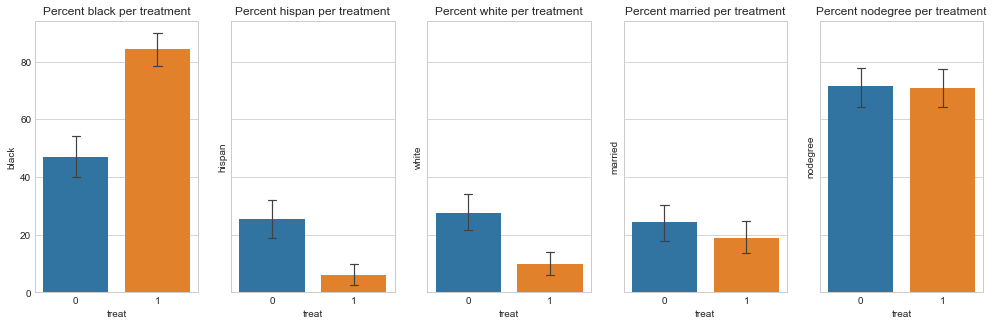

In [32]:
barplot_categories(data_naive_match)

#### Comment of categorical distributions
- One can clearly see big differences between the treatmentgroups in the features containing race. It is a big improvement from before matching. But it is not close to a matching where we could assume treatment group and control group where drawn from the same population.

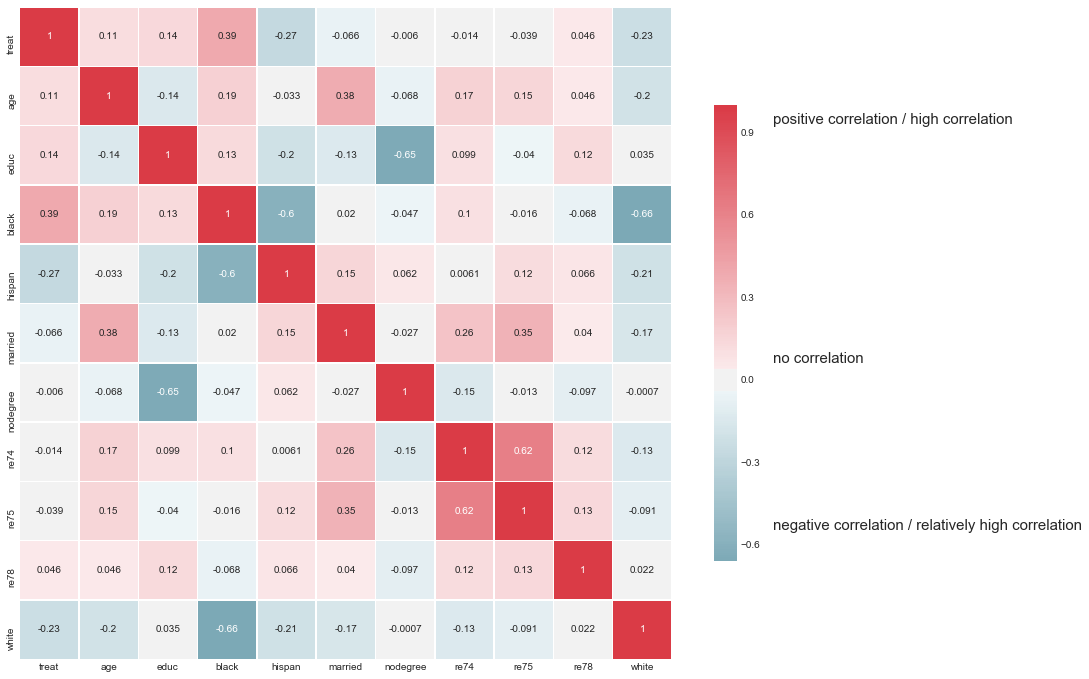

In [33]:
data = data_naive_match
data = data.drop('propensity', 1)
corr_mat(data)

#### Comment on correlation matrix:
- If the treatment groups where drawn from the same population then the correlation between all the other features except 're78' should be close to zero. But because we did a bad matching we can see that the races are very correlated to treat.

### Does the features have a more similar distributions than before matching?
The features have a more similar distribution but the the datasets are too different, one can not match the whole treatment datset with the control group for that reason.

One can clearly see hear that when one matches ALL of the people in the treatmentgroup then we can not match sufficiently "similar" people. We must match the groups with somekind of threshold, with the cost of loosing parts of the dataset if we are to get some good results

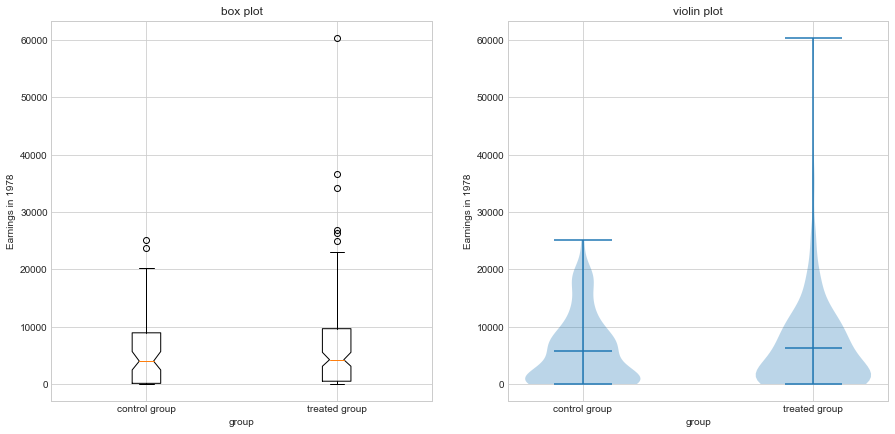

In [35]:
boxplot_and_violinplot(data_naive_match, 're78', 'Earnings in 1978') 

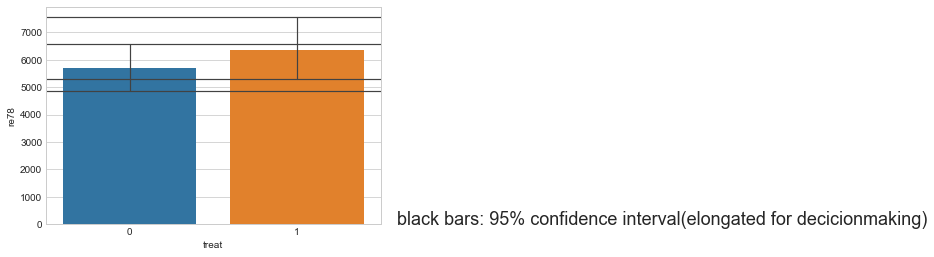

In [36]:
barplot_re78(data_naive_match)

#### Are we any closer to beeing able to draw a conclusion?
Because we don't have a unbiased sampled treatment dataset one can not draw any conclusions from it yet. But we can comment the chances in the earnings in 1978. The mean has changed from beeing almost statistically significant negative effect to having a almost statistically significant(if we could draw conclusions) positive effect. This is a big shift in the trend

___
## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

### The "balanced" dataset:
- The balanced dataset was not near to beeing a balanced dataset, therefore we must balance it further.
- We can only draw conclusions if we have a unbiased sampling of the treatment groups.

To create a balanced dataset we will use the numbers from the correlation matrix as a evaluation parameter and optimize on those.
The parameters are designed by our team as a way to asses:
   1. the BIAS of the sampling of the treatmentgroups
       - the sum of all the corrolations with treat except 'treat' itself and 're78' 
   2. the EFFECT on 're78' of the bias in the sampling of the treatmentgroups
       - the sum of the correlations between treat times others * corrolations with 're78'

I will not to an extensive grid search of possible values and possible features to balance out, but now that this is possible but I assume it is not within the scope of this homework

From earlier experimentation we saw that just adjusting the threshold of adding weights address the problem of evening out corrolation with especially race. Therefore we will only optimize with adjusting the threshold.


In [ ]:
# Setting the variables before optimizing
data = data_propensity
thresholds = [0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
bias_score = []
effect_score = []

for t in thresholds:
    data_poss_match = matching_groups(data, threshold=t)
    data_poss_match = data_poss_match.drop('propensity', 1)
    matched_corr = data_poss_match.corr()
    bias_score.append(sum(np.abs(matched_corr.treat)) - 1) #0.423
    effect_score.append(sum(matched_corr.treat*matched_corr.re78) - matched_corr.treat.re78*2) #0.0062 


In [38]:
print("Thresholds: ", thresholds)
print("Bias-scores: ", bias_score)
print("Effect-scores: ", effect_score)
index_best = np.argmin(np.add(bias_score, effect_score))
print("Best threshold:",thresholds[index_best])

# do last matching on the best threshold
data_match = matching_groups(data, threshold=thresholds[index_best])


Thresholds:  [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
Bias-scores:  [0.44600892292165728, 0.42723603898509221, 0.40850678038971378, 0.43169612120041578, 0.47097360934426336, 0.49140443448525173, 0.48306709163049777, 0.47294468670663314, 0.49923556538482883, 0.45920851767476734]
Effect-scores:  [0.00096427415363029012, 0.0019535541865748351, 0.0020752247030874638, 0.0088864989459099264, 0.013562438554151068, 0.016595672876476064, 0.01802834180512905, 0.016556205256123668, 0.016982941870374024, 0.0091557959851504001]
Best threshold: 0.92
number of pairs that matches 117.0
previous number of subjects in treatmentgroup/ max matches: 185

average propensityscores(control,treatment): (0.48783488320120794, 0.4974431059283927)


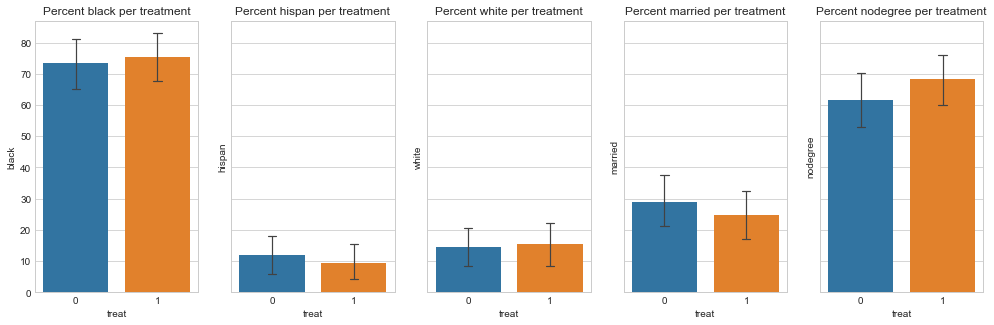

In [39]:
barplot_categories(data_match)

measure of bias in sampling in treatmentgroup 0.430383695308
measure of effect of bias on re78:  -0.000471147829891


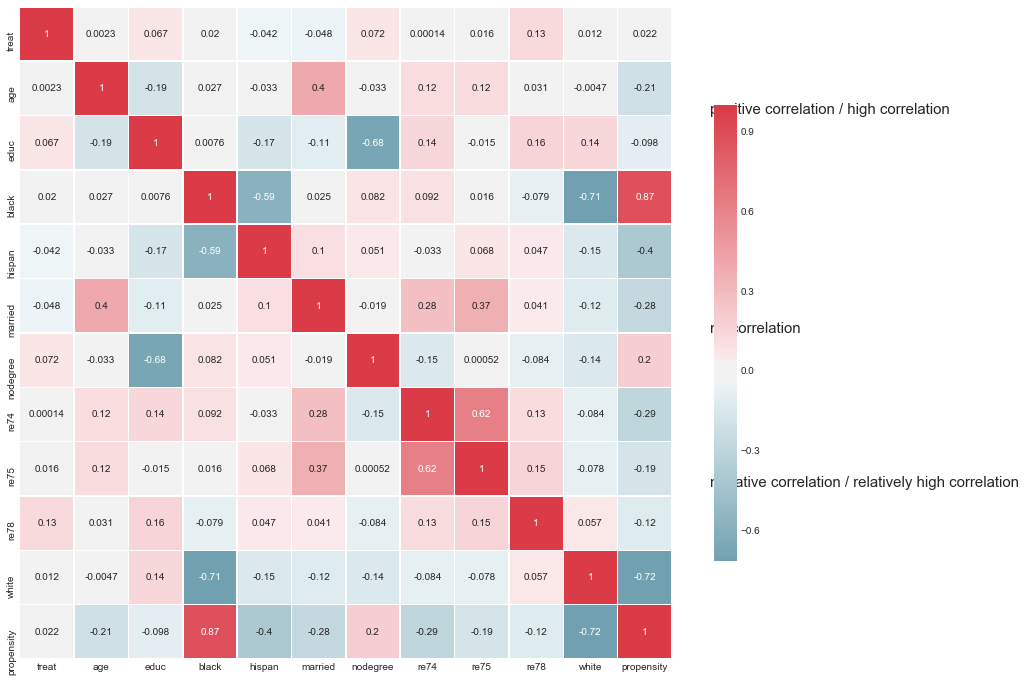

In [40]:
corr_mat(data_match)
data = data.drop('propensity', 1)
matched_corr = data_match.corr()
print("measure of bias in sampling in treatmentgroup", sum(np.abs(matched_corr.treat)) - 1) #0.423
print("measure of effect of bias on re78: ", sum(matched_corr.treat*matched_corr.re78) - matched_corr.treat.re78*2) #0.0062   

___
## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


#### Assumptions:
Now we have done a analysis and tried to balance the treatment sampling. We assume that we have controlled for other the other known features. We will know investigate one can conclude if treatment had an statistically significant effect.

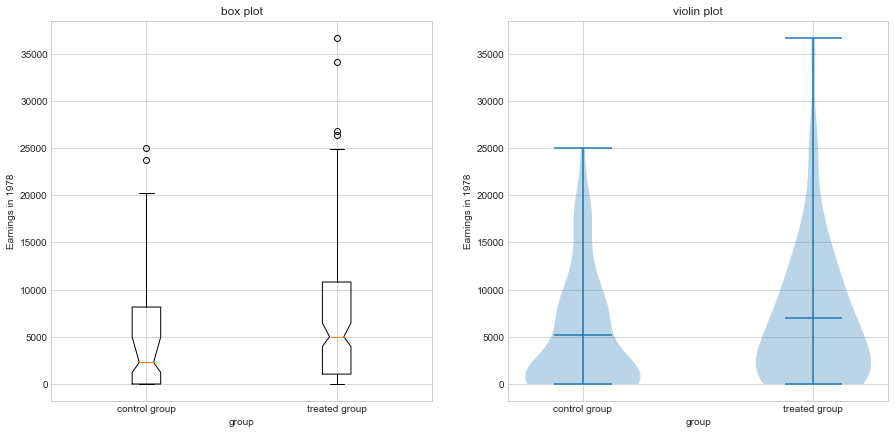

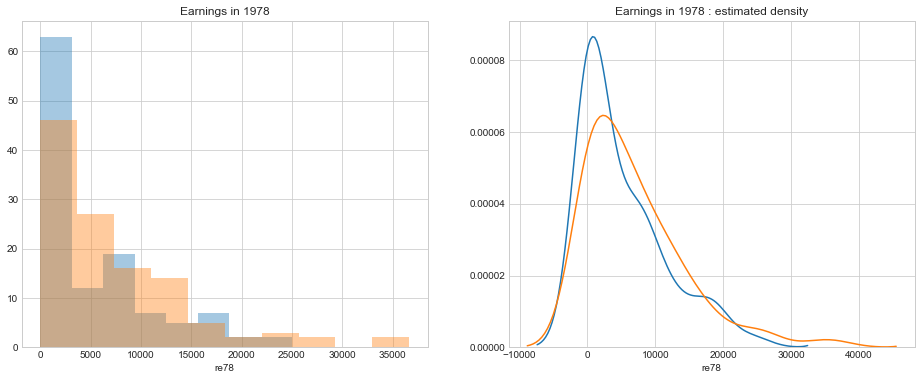

Control group is blue and treated group is orange


In [41]:
eval_distribution(data_match,'re78', 'Earnings in 1978')

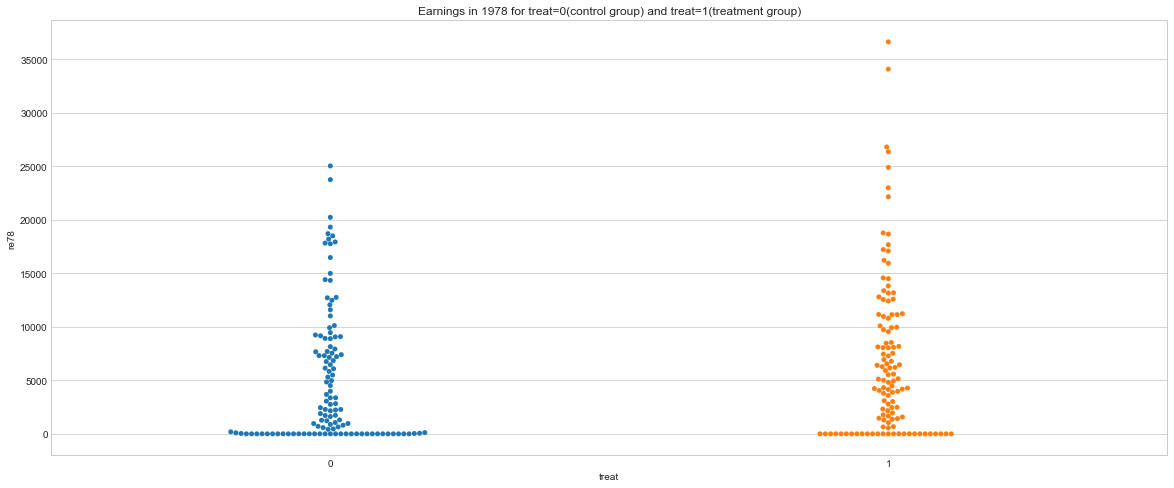

In [42]:
swarmplot_re78(data_match)

#### Comment to swarmplot:
- As you can see the unemployment is slightly higher in controlgroup than in the treatment group
- If you compare with the first swarmplot in the start of the report you can see that the anomaly in the controllgroup has disappeared, filtered out through the matchingprosess. This is probably partially why the controlgroup has declined very much

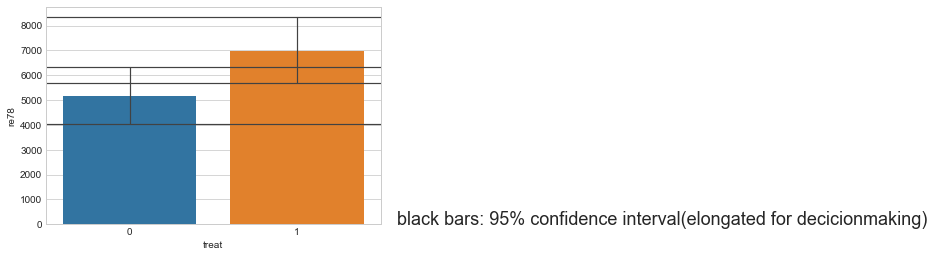

In [43]:
barplot_re78(data_match)

### Conclusion
Doing the same nullhypothesis testing as earlier one can see that the nullhypothesis does not hold with a 95% confidence interval, the alternative hypothesis is adopted. The treatment had a positive effect on the future earnings of the treated subjects. How big the effect is is harder to estimate. But it had an positive effect with a over 95% confidence

##### General comments on the observed study
- The assumption that one could use the propensity score to make the sample unbiased was based one the "naive model" that there are not other external unobserved features we don't have. This should be adressed with a sensitivity analysis. We assumed this was not in the scope of this course.
- there is lots of information that we dont have about the people, maybe the feature chosen arent the best maybe we could do better with other information. IQ-score, credithistory, personalitytest or other features. We did not collect the data so we have little information about how it is collected


___
___

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


    2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



In [2]:
#Importing the dataset, and the sklearn items we will need
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
import sklearn.metrics as skm
from matplotlib.colors import LogNorm


In order to use the TF-IDF, we first need to load the entire dataset and then cut it into the required size (10% of it for both training and testing).
Once this is done we compute the TF-IDF values in the training and testing sets.

In [3]:
#Loading the dataset
newsgroup = fetch_20newsgroups(subset='all')

#Defining categories and making sure they are the right ones.
categories = newsgroup.target_names
display(categories)

#Dividing the dataset into what we want.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(newsgroup.data, newsgroup.target, test_size = 0.1, 
                                                random_state = 3, stratify = newsgroup.target)

#Creating the vectorizer, we use the English stop words in order to make it more efficient.
vectorizer = TfidfVectorizer(stop_words='english').fit(Xtrain)

#Using the algorithm for the training set
Xtrain = vectorizer.transform(Xtrain)

#And for the testing set
Xtest = vectorizer.transform(Xtest)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

###### Comment
The subsets are fully implemented, we can now move on the Random Forest part.

#### Question 2.2

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.
 

##### Resolution
We will implement the random forest, then play with the given features in order to have a look on their influence.
Because we need to vary both the number of estimators and the maximum depth, we create a function with the random forest alogrithm that returns the accuracy.
The grid search is implemented with n_estimators in [10, 50] and max_depth in [1000, 10000]. One could argue that there are not the most efficient ranges, however our computers would not allow to have values above our upper bounds (the computation takes too much time).
We use n_jobs = - 1 in order to use all the processors on the computer which is running the algorithm.

In [5]:
def RdmForest(estimators,depth):
    Classifier = RandomForestClassifier(n_estimators=estimators, max_depth=depth, n_jobs = - 1)
    Classifier.fit(Xtrain,Ytrain)
    #Implementing the confusion matrix
    Conf_matrix = skm.confusion_matrix(Ytest, Classifier.predict(Xtest))
    #Computing the accuracy, which corresponds to the sum of the values on the diagonal (right assessment) over the total value
    #of the matrix (every assessement). 
    Accuracy  = np.diag(Conf_matrix).sum()/Conf_matrix.sum()
    
    return Accuracy

Computation of the confusion matrix:
We apply grid search on the random forest algorithm, and then we plot the results.

In [6]:
#We make the two parameters vary in order to tune them.
Accuracy_results = pd.DataFrame(columns=['Number_estimators', 'max_tree_depth', 'Result'])
i = 10
while i <= 50 :
    j = 1000
    while j<= 10000:
        #Appending the results
        Accuracy_results.loc[i+j] = [i, j, RdmForest(i, j)] 
        j += 1000
                                     
    i+=10
    
#Reseting the dataframe's index because the implementation's structure shuffled the index
Accuracy_results = Accuracy_results.sort_values('Result')
Accuracy_results = Accuracy_results.reset_index()
Accuracy_results = Accuracy_results.drop('index', axis=1)

,Number_estimators,max_tree_depth,Result
40,50.0,6000.0,0.841910
41,40.0,7000.0,0.842440
42,50.0,1000.0,0.842971
43,50.0,10000.0,0.844562
44,50.0,5000.0,0.845623
45,50.0,7000.0,0.846154
46,50.0,3000.0,0.846684
47,50.0,9000.0,0.846684
48,50.0,4000.0,0.848806
49,40.0,9000.0,0.849337


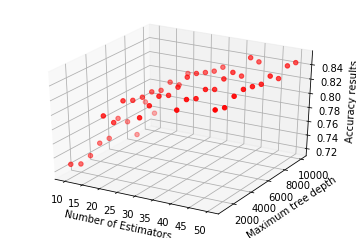

In [14]:
#Creating a copy in order to keep the initial results as they are.
Acc_copy = Accuracy_results.copy()
#Showing the results
display(Acc_copy.tail(10))

#Plotting the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x=Acc_copy['Number_estimators']
y=Acc_copy['max_tree_depth']
z=Acc_copy['Result']

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Maximum tree depth')
ax.set_zlabel('Accuracy results')

plt.show()


##### Comments:

We notice that if the number of estimator increases or the maximum tree depth increases, the algorithm gets more accurate. 

Now that we know that the most productive inputs are:
- n = 50 for the number of estimators
- m_d = 6000 for the maximum depth

We use those 2 values to get the importance of the various features. 

It is however important to highlight that the analysis is incomplete. Our computers did not allow to extend the gridsearch further because of the computing time that was getting too big. The parameter that has the strongest influence is the number of estimators, but it is also the one that increases the computing time. 
We pick those two values because they provide a high accuracy, but we are fully aware that an extended work would be required to find the optimal parameters. 

In [15]:
#Create the finest tuned random forest classifier
Forest = RandomForestClassifier(n_estimators=50 ,max_depth=6000)
Forest.fit(Xtrain,Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6000, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
#Computing the confusion matrix
Confusion_matrix = skm.confusion_matrix(Ytest, Forest.predict(Xtest))

In order to display the confusion matrix properly, we use a heatmap from the seaborn library. We first convert our results to a DataFrame, then we plot it.
In order to distinguish accuracy and inaccuracy, we compute the percentage of right classification and misclassification on each row. 

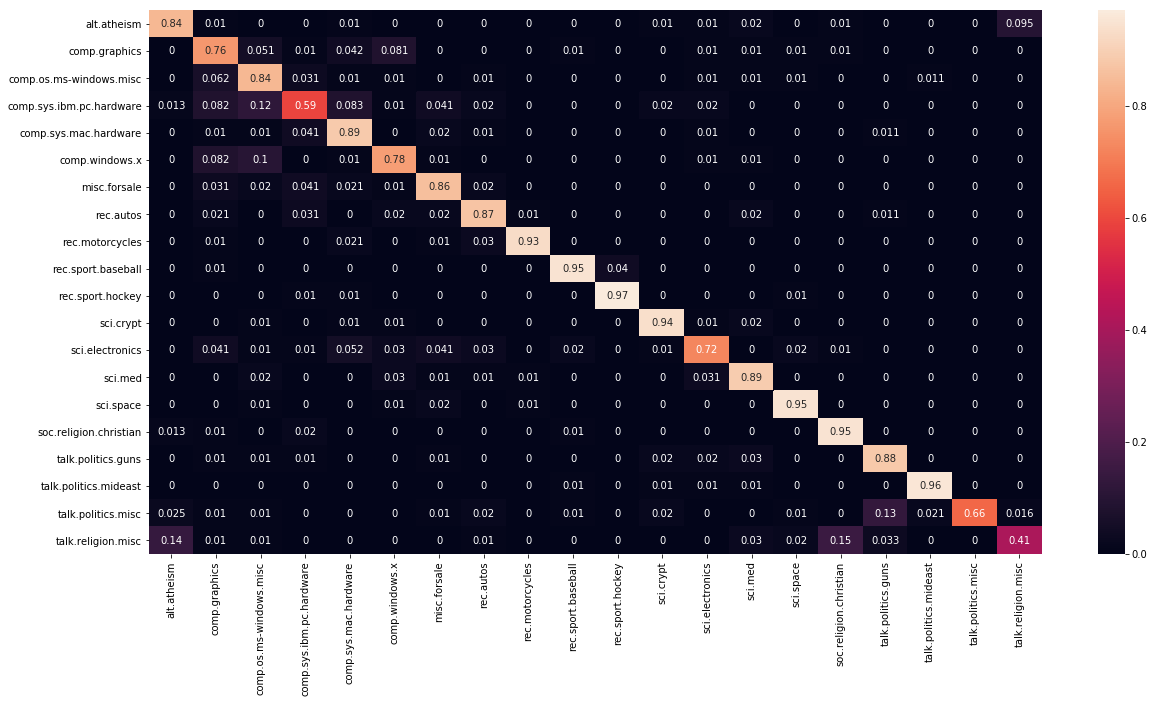

In [17]:
plt.figure(figsize=(20 , 10))
sns.heatmap(pd.DataFrame(Confusion_matrix)/pd.DataFrame(Confusion_matrix).sum(axis=1), 
            annot=True, yticklabels=categories, xticklabels=categories)
            #yticklabels=categories , xticklabels=categories)

#### Comments
Recall that the real feature are along y, and the estimated are along x.
One can notice that the algorithm is not performant for specific categories, and especially when topics are close to one another. For instance the comp.graphics (58% accuracy) has more misclassification with:
- comp.os.ms.windows.misc
- comp.windows.x

Which is normal because it is dealing with the same topic, meaning that the words that are used in the TF-IDF must be similar, if not the same for certain cases.
Such phenomenon could also be highlighted with political talks (68% accuracy) and guns, or with religion (43% accuracy) and atheism or christianism. 

#### Feature importance

There is a pre-implemented sklearn method to get the feature importance, we will use it

In [18]:
#Getting the importance of each feature and appending results to a dataframe.
Imp_features = pd.DataFrame(Forest.feature_importances_, columns=["Importance"])

#Computing the standard deviation for each feature
Imp_features['Std'] = np.std([tree.feature_importances_ for tree in Forest.estimators_], axis=0)

#Displaying the number of features
display(Imp_features['Importance'].size)

153725

Because there are way too many features, we will just plot the most important ones.

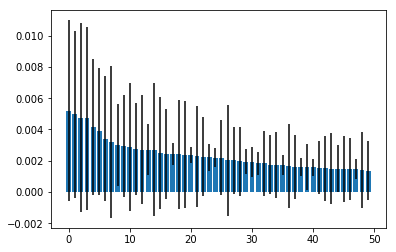

In [19]:
Imp_features = Imp_features.sort_values('Importance', ascending=False)

#Taking the most important values
Imp_reduced = Imp_features.head(50)

#Plotting results
x = range(Imp_reduced.shape[0])
y = Imp_reduced.iloc[:, 0]
yerr = Imp_reduced.iloc[:, 1]
plt.bar(x, y, yerr=yerr, align="center")
plt.show()

Because standard deviation seems a bit high when looking at the graph, we will compute the coefficient of variation (Std/mean). It is considered that the variation is high if the coefficient is superior to 1. Let's compute the number of features that are above this value.

In [20]:
Imp_features['Variation_coef'] = (Imp_features['Std'])/Imp_features['Importance'].mean()
display(Imp_features[Imp_features['Variation_coef'] > 1].shape[0])

40205

### Discussion of the results

Has it is shown with the number of features that have a big coefficient of variation, many features are not meaningfull. However one must bear in mind that there are 153725 of them, and the classifier is not taking into account one in particular but rather a set of them. The importance of each feature is not relevant as such, it is their combination that makes them accurate. 
Our final plot shows that most features have to much standard deviation, but it is not the main parameter to consider when dealing with a random forest. 